## Preprocessing Pipeline

This notebook uses a deep convolutional neural network (CNN) to extract features from input images. It follows the approach described in [[1]](https://arxiv.org/abs/1503.03832) with modifications inspired by the [OpenFace](http://cmusatyalab.github.io/openface/) project. [Keras](https://keras.io/) is used for implementing the CNN, [Dlib](http://dlib.net/) and [OpenCV](https://opencv.org/) for aligning faces on input images. 

- Detect, transform, and crop faces on input images. This ensures that faces are aligned before feeding them into the CNN. This preprocessing step is very important for the performance of the neural network.

### Environment setup

For running this notebook, create and activate a new [virtual environment](https://docs.python.org/3/tutorial/venv.html) and install the packages listed in [requirements.txt](requirements.txt) with `pip install -r requirements.txt`. Furthermore, you'll need a local copy of Dlib's face landmarks data file for running face alignment:

In [1]:
!git clone https://github.com/05rs/Face-Recogination.git
import sys
sys.path.append('./Face-Recogination/FaceNet')
# !pip install -r '/content/Face-Recogination/FaceNet/requirements.txt'
import align
import data
import utils
import model
import matplotlib.pyplot as plt
from model import create_model

Cloning into 'Face-Recogination'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 447 (delta 10), reused 25 (delta 2), pack-reused 407
Receiving objects: 100% (447/447), 133.66 MiB | 27.51 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (617/617), done.


In [2]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = '/content/Face-Recogination/FaceNet/models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

### Custom dataset
To demonstrate face recognition on a custom dataset, a small subset of the [LFW](http://vis-www.cs.umass.edu/lfw/) dataset is used. It consists of 100 face images of [10 identities](images). The metadata for each image (file and identity name) are loaded into memory for later processing.

In [3]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('/content/Face-Recogination/FaceNet/images')

### Face alignment

The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use [Dlib](http://dlib.net/) for face detection and [OpenCV](https://opencv.org/) for image transformation and cropping to produce aligned 96x96 RGB face images. By using the [AlignDlib](align.py) utility from the OpenFace project this is straightforward:

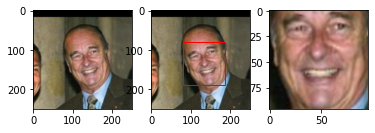

In [5]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('/content/Face-Recogination/FaceNet/models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[77].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [6]:
import align
import data
import utils
import model
from model import create_model

nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('/content/Face-Recogination/FaceNet/weights/nn4.small2.v1.h5')

As described in the OpenFace [pre-trained models](https://cmusatyalab.github.io/openface/models-and-accuracies/#pre-trained-models) section, landmark indices `OUTER_EYES_AND_NOSE` are required for model nn4.small2.v1. Let's implement face detection, transformation and cropping as `align_image` function for later reuse.

In [7]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Embedding vectors

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [8]:
seq = {str(m.name):float(i) for i,m in enumerate(metadata)}
embedded = np.zeros((metadata.shape[0], 128))
label = []
images = np.zeros((metadata.shape[0],96,96,3))
itr =  np.zeros((metadata.shape[0], 1))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    images[i] = img
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    label.append(seq[str(metadata[i].name)])
    
    itr[i] = i
label = np.array(label).reshape((metadata.shape[0], 1)) 

print("Number of image classes: ",len(seq.keys()))
print("Shape of itr (image iterator): ",itr.shape)
print("Shape of embedded vector: ",embedded.shape)
print("Shape of label (encoded labels): ",label.shape)
print("Shape of images:",images.shape)

Number of image classes:  10
Shape of itr (image iterator):  (100, 1)
Shape of embedded vector:  (100, 128)
Shape of label (encoded labels):  (100, 1)
Shape of images: (100, 96, 96, 3)


Saving the preprocessed data to pkl

In [10]:
import pickle

processed_data = {'seq': seq,
           'itr': itr,
           'embedded': embedded,
           'label' : label,
           'images' : images,            
          }
output = open('/content/Face-Recogination/FaceNet/data/data.pkl', 'wb')
pickle.dump(processed_data, output)
output.close()